### Calculate habitat variables
* Extracts raster values within RCA polygons and calculates summary statistic for each variable
* Calculates areas of polygons (kelp, eelgrass and sponge reefs) within RCAs
* Exports variables as csv file

In [6]:
# Import necessary modules
from rasterstats import zonal_stats, point_query
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pandas as pd
from sklearn.preprocessing import PowerTransformer # for data transformations

In [7]:
# Paths to data

# RCAs
rcas = "/mnt/d/Projects/RCA-monitoring/Data/RCA2019/RCA_2019_albers.shp"

# Habitat rasters
depth = "/mnt/e/Substrate/RCAs/PredictorLayers/RCA_Masked/bathymetry.tif"
slope = "/mnt/e/Substrate/RCAs/PredictorLayers/RCA_Masked/slope.tif"
complexity = "/mnt/e/Substrate/RCAs/PredictorLayers/RCA_Masked/bpi_fine.tif" # inner=3, outer=25
exposure = "/mnt/e/Substrate/RCAs/PredictorLayers/RCA_Masked/fetch.tif"
tidal = "/mnt/e/Substrate/RCAs/PredictorLayers/RCA_Masked/tidal.tif"
rock = "/mnt/e/Substrate/RCAs/Results/Substrate_RCAs.tif"
uncert = "/mnt/e/Bathymetry/20m/RCAmosaic/DataDensity_RCA_Bathymetry_20m.tif"

# Habitat polygons
kelp_file="/mnt/f/SpeciesData/Inverts_Algae/Kelp/All_Kelp_Combined.gdb"
kelp_layer= "all_dissolved_rcas"
eelgrass_file="/mnt/f/SpeciesData/Inverts_Algae/Eelgrass/MSP/mpatt_eco_plants_eelgrass.gdb"
eelgrass_layer="mpatt_eco_plants_eelgrass_polygons_data_dissolved_rcas"
sponge_file="/mnt/f/SpeciesData/Inverts_Algae/SpongeReefs/sponge_reefs.gdb"
sponge_layer="sponge_reefs_all_rcas"

In [8]:
# Load csv with RCA area values for calculating proportion
geo = pd.read_csv("Geographic/georgraphic_variables.csv")

In [9]:
# Depth
# Range from the 5th to 95th percentile
depth_stats = zonal_stats(rcas, depth, stats="percentile_5 percentile_95")
depth_var = np.array( [i["percentile_95"] for i in depth_stats] ) - np.array( [i["percentile_5"] for i in depth_stats] )
plt.hist(depth_var)

(array([46., 38., 30., 20., 14.,  5.,  4.,  1.,  1.,  3.]),
 array([  7.2545627 ,  59.05305925, 110.8515558 , 162.65005234,
        214.44854889, 266.24704544, 318.04554199, 369.84403854,
        421.64253508, 473.44103163, 525.23952818]),
 <BarContainer object of 10 artists>)

In [10]:
# Slope
# Mean
slope_stats = zonal_stats(rcas, slope, stats="mean")
slope_var = np.array( [i["mean"] for i in slope_stats] )
plt.hist(slope_var)

(array([22., 43., 33., 22., 12., 12.,  8.,  6.,  3.,  1.]),
 array([ 0.65720217,  3.23312988,  5.8090576 ,  8.38498531, 10.96091303,
        13.53684074, 16.11276846, 18.68869617, 21.26462389, 23.8405516 ,
        26.41647932]),
 <BarContainer object of 10 artists>)

In [11]:
# Complexity
# Mean fine bpi
complexity_stats = zonal_stats(rcas, complexity, stats="mean")
complexity_calc = np.array( [i["mean"] for i in complexity_stats] ) 
# # Transform to make the probability distribution of a variable more Gaussian
# # Stabilizing the variance of the distribution
# power = PowerTransformer(method='yeo-johnson', standardize=False)
# complexity_trans = power.fit_transform(complexity_calc.reshape(-1, 1))
# create index from 0 to 1 that is easier to interpret
complexity_var = (complexity_calc - min(complexity_calc)) / ( max(complexity_calc) - min(complexity_calc) ) 
plt.hist(complexity_var)

(array([ 1.,  1.,  1.,  6.,  8.,  8., 18., 32., 76., 11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

(array([110.,  24.,   6.,   0.,   3.,   2.,   6.,   4.,   4.,   3.]),
 array([0.00235647, 0.05256967, 0.10278287, 0.15299608, 0.20320928,
        0.25342248, 0.30363568, 0.35384888, 0.40406209, 0.45427529,
        0.50448849]),
 <BarContainer object of 10 artists>)

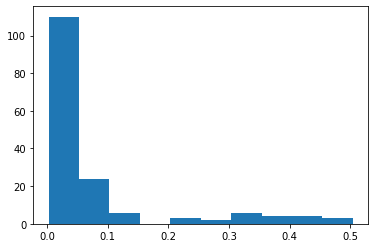

In [12]:
# Exposure
# Mean
exposure_stats = zonal_stats(rcas, exposure, stats="mean")
exposure_var = np.array( [i["mean"] for i in exposure_stats] )
plt.hist(exposure_var)

(array([65., 37., 34.,  7.,  4.,  4.,  4.,  4.,  1.,  2.]),
 array([0.00889697, 0.06908299, 0.12926902, 0.18945505, 0.24964107,
        0.3098271 , 0.37001313, 0.43019915, 0.49038518, 0.55057121,
        0.61075724]),
 <BarContainer object of 10 artists>)

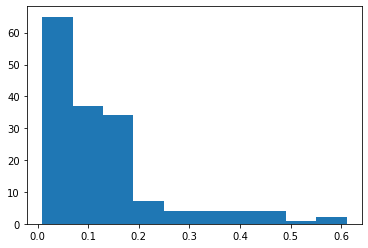

In [13]:
# Tidal
# Mean
tidal_stats = zonal_stats(rcas, tidal, stats="mean")
tidal_var = np.array( [i["mean"] for i in tidal_stats] )
plt.hist(tidal_var)

In [14]:
# Rock
# Area of rock in km2 (number of cells * 20 x 20m)
rock_stats = zonal_stats(rcas, rock, categorical=True)
rock_var = np.array( [i[1.0] for i in rock_stats] ) * 20 * 20 / 1000 / 1000
# Adjust area values by dividing by area to get proportion
rock_var = rock_var / geo['Area']
plt.hist(rock_var)

(array([14., 12., 31., 31., 25., 16., 15., 10.,  4.,  4.]),
 array([0.00869396, 0.10694466, 0.20519535, 0.30344605, 0.40169674,
        0.49994744, 0.59819813, 0.69644883, 0.79469952, 0.89295022,
        0.99120091]),
 <BarContainer object of 10 artists>)

In [15]:
# Bathy data density
# Mean
uncert_stats = zonal_stats(rcas, uncert, stats="mean")
uncert_var = np.array( [i["mean"] for i in uncert_stats] )
plt.hist(uncert_var)

(array([18., 10., 11., 12., 11.,  8.,  3., 12., 39., 38.]),
 array([0.01098714, 0.10988843, 0.20878971, 0.307691  , 0.40659229,
        0.50549357, 0.60439486, 0.70329614, 0.80219743, 0.90109871,
        1.        ]),
 <BarContainer object of 10 artists>)

In [16]:
# Load RCA polygons to get FID and RCA name
rca_polys = gp.read_file(rcas)
polysdf = pd.DataFrame(rca_polys)
rcadat = polysdf.iloc[:,0:1]

In [17]:
# Kelp
# Area km2
kelp_polys = gp.read_file(kelp_file, layer=kelp_layer)
kelp_rcas = gp.overlay(rca_polys, kelp_polys, how='intersection')
kelp_rcas['kelp_area_sqkm'] = kelp_rcas['geometry'].area / 10**6
kelp_var = rcadat.join(kelp_rcas[['NAME', 'kelp_area_sqkm']].set_index('NAME'), on='NAME')
kelp_var = np.array( kelp_var['kelp_area_sqkm'].fillna(0) )
# Adjust area values by dividing by area to get proportion
kelp_var = kelp_var / geo['Area']
plt.hist(kelp_var)

(array([118.,  21.,   5.,   5.,   3.,   3.,   1.,   2.,   2.,   2.]),
 array([0.        , 0.08442572, 0.16885144, 0.25327717, 0.33770289,
        0.42212861, 0.50655433, 0.59098005, 0.67540578, 0.7598315 ,
        0.84425722]),
 <BarContainer object of 10 artists>)

(array([152.,   4.,   2.,   0.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([0.        , 0.02921867, 0.05843733, 0.087656  , 0.11687467,
        0.14609334, 0.175312  , 0.20453067, 0.23374934, 0.262968  ,
        0.29218667]),
 <BarContainer object of 10 artists>)

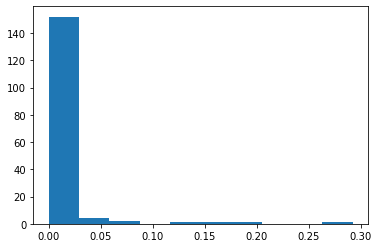

In [18]:
# Eelgrass
# Area km2
eelgrass_polys = gp.read_file(eelgrass_file, layer=eelgrass_layer)
eelgrass_rcas = gp.overlay(rca_polys, eelgrass_polys, how='intersection')
eelgrass_rcas['eelgrass_area_sqkm'] = eelgrass_rcas['geometry'].area / 10**6
eelgrass_var = rcadat.join(eelgrass_rcas[['NAME', 'eelgrass_area_sqkm']].set_index('NAME'), on='NAME')
eelgrass_var = np.array( eelgrass_var['eelgrass_area_sqkm'].fillna(0) )
# Adjust area values by dividing by area to get proportion
eelgrass_var = eelgrass_var / geo['Area']
plt.hist(eelgrass_var)

(array([156.,   0.,   3.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.03116486, 0.06232973, 0.09349459, 0.12465946,
        0.15582432, 0.18698919, 0.21815405, 0.24931892, 0.28048378,
        0.31164865]),
 <BarContainer object of 10 artists>)

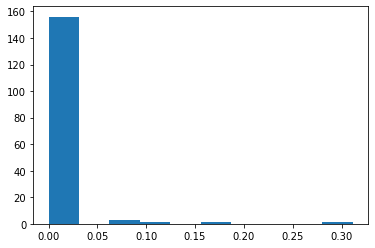

In [19]:
# Sponge reef
# Area km2
sponge_polys = gp.read_file(sponge_file, layer=sponge_layer)
sponge_rcas = gp.overlay(rca_polys, sponge_polys, how='intersection')
sponge_rcas['sponge_area_sqkm'] = sponge_rcas['geometry'].area / 10**6
sponge_sum = sponge_rcas[['NAME','sponge_area_sqkm']].groupby(by="NAME").sum().reset_index()
sponge_var = rcadat.join(sponge_sum.set_index('NAME'), on='NAME')
sponge_var = np.array( sponge_var['sponge_area_sqkm'].fillna(0) )
# Adjust area values by dividing by area to get proportion
sponge_var = sponge_var / geo['Area']
plt.hist(sponge_var)

In [20]:
# Add variables to dataframe with FID and RCA name fields
allvars = np.column_stack( (depth_var, slope_var, complexity_var, rock_var, exposure_var, tidal_var, uncert_var, 
                            kelp_var, eelgrass_var, sponge_var) )
dat = pd.concat([rcadat, pd.DataFrame(allvars)], axis=1)
dat.columns = ["Name", "Depth", "Slope", "Complexity", "Rock", "Exposure", "Tidal", "BathyQuality", "Kelp", "Eelgrass", "SpongeReef"]
dat.to_csv('Habitat/habitat_variables.csv')
dat

Name       Depth      Slope  Complexity  \
0               Ajax / Achilles Bank  120.432988   2.579934    0.880112   
1                    Ballenas Island  382.061662  15.188045    0.887081   
2            Bate - Shadwell Passage   77.644469   3.681859    0.830494   
3          Baynes Sound - Ship Point   32.881484   3.727701    0.793154   
4                    Becher Bay East   47.498712   7.319720    0.860126   
..                               ...         ...        ...         ...   
157  West Cracroft Island - Boat Bay  229.078166  15.073741    0.892138   
158                West of Bajo Reef   41.148980   0.657202    0.871028   
159                   West Vancouver  165.600623  11.791869    0.800500   
160                  Weynton Passage  134.396134   9.437112    0.859791   
161                 Woolridge Island  213.278770  19.761995    0.361046   

         Rock  Exposure     Tidal  BathyQuality      Kelp  Eelgrass  \
0    0.051005  0.074503  0.059112      0.996476  0.000000  0.000000   
1    0.211847  0.077727  0.065573      0.924338  0.000000  0.000000   
2    0.429945  0.072302  0.188952      0.406688  0.249120  0.000000   
3    0.138425  0.010698  0.043647      0.906780  0.000000  0.000000   
4    0.728917  0.036646  0.144316      0.572028  0.401065  0.000000   
..        ...       ...       ...           ...       ...       ...   
157  0.889554  0.015049  0.449897      0.600725  0.086302  0.000000   
158  0.223020  0.433199  0.131985      0.019610  0.000000  0.000000   
159  0.270116  0.037158  0.050946      0.924605  0.000000  0.000267   
160  0.852956  0.016330  0.410791      0.289868  0.075939  0.000000   
161  0.383428  0.006871  0.020265      0.827511  0.000000  0.000000   

     SpongeReef  
0      0.012685  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  
..          ...  
157    0.000000  
158    0.000000  
159    0.091510  
160    0.000000  
161    0.000000  

[162 rows x 11 columns]

array([[1.        , 0.74467433],
       [0.74467433, 1.        ]])

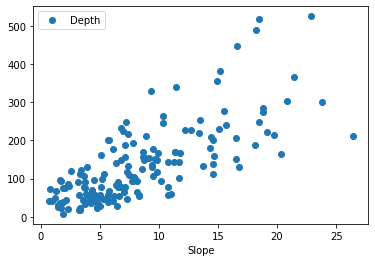

In [21]:
# Check for correlations between slope and depth
dat.plot(x='Slope', y='Depth', style='o')
np.corrcoef(dat['Slope'], dat['Depth'])

<AxesSubplot:xlabel='Slope'>

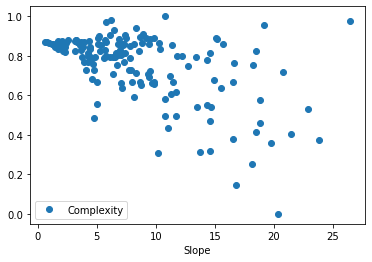

In [22]:
# Slope and complexity
dat.plot(x='Slope', y='Complexity', style='o')

<AxesSubplot:xlabel='Depth'>

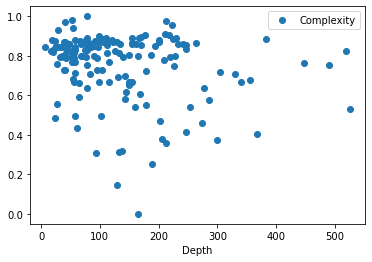

In [23]:
# Depth and complexity
dat.plot(x='Depth', y='Complexity', style='o')

In [24]:
# High tidal (95%)
dat[dat.Tidal > dat['Tidal'].quantile(.95)]

Name       Depth      Slope  Complexity  \
24                   Chancellor Inlet West  285.325551  18.788401    0.575993   
30   Cracroft Point South - Sophia Islands   57.138235   8.285154    0.712993   
43          Drury Inlet - Muirhead Islands   40.466852   4.059588    0.730459   
51                         Forward Harbour   23.473608   4.775457    0.485399   
84                             Maud Island   67.187665   5.791715    0.799864   
115                             Race Rocks   40.202965   5.766577    0.968383   
152                              Wellborne  178.116432   9.537944    0.722372   
157        West Cracroft Island - Boat Bay  229.078166  15.073741    0.892138   
160                        Weynton Passage  134.396134   9.437112    0.859791   

         Rock  Exposure     Tidal  BathyQuality      Kelp  Eelgrass  \
24   0.423347  0.006462  0.451114      0.857788  0.110801  0.000000   
30   0.891823  0.010995  0.493019      0.244964  0.326241  0.000000   
43   0.528409  0.004339  0.393257      0.012603  0.008589  0.000000   
51   0.292066  0.002596  0.435751      0.011579  0.047393  0.000000   
84   0.639917  0.007766  0.557108      0.333275  0.152818  0.000000   
115  0.991201  0.120133  0.610757      0.995949  0.461759  0.000000   
152  0.324823  0.009440  0.444797      0.012927  0.086893  0.007818   
157  0.889554  0.015049  0.449897      0.600725  0.086302  0.000000   
160  0.852956  0.016330  0.410791      0.289868  0.075939  0.000000   

     SpongeReef  
24          0.0  
30          0.0  
43          0.0  
51          0.0  
84          0.0  
115         0.0  
152         0.0  
157         0.0  
160         0.0

In [25]:
 # high complexity (95%)
dat[dat.Complexity >  dat['Complexity'].quantile(.95)]

Name       Depth      Slope  Complexity  \
12                  Bowyer Island  212.058040  26.416479    0.975922   
32                   Danger Reefs   52.923035   6.180682    0.978495   
62                   Halibut Bank  176.961448   6.084866    0.907407   
63   Hardy Bay - Five Fathom Rock   28.279773   6.465800    0.928860   
76    Lasqueti South -Young Point  211.176125   8.915466    0.908262   
103                      Pam Rock  223.135909  19.130206    0.955530   
105                Passage Island   77.919680  10.806690    1.000000   
106                    Patey Rock   54.589850   8.324260    0.940819   
115                    Race Rocks   40.202965   5.766577    0.968383   

         Rock  Exposure     Tidal  BathyQuality      Kelp  Eelgrass  \
12   0.415313  0.019715  0.031308      0.844759  0.000000  0.001322   
32   0.902294  0.021196  0.048937      0.281120  0.000000  0.000000   
62   0.018437  0.103668  0.077343      0.990296  0.000000  0.000000   
63   0.916734  0.024192  0.175097      0.837221  0.000000  0.000000   
76   0.010355  0.090819  0.044021      0.993153  0.000000  0.000000   
103  0.311721  0.017662  0.023412      0.887904  0.000000  0.000000   
105  0.725196  0.063349  0.065111      0.881378  0.000000  0.000000   
106  0.537634  0.015948  0.126016      0.892205  0.000000  0.000000   
115  0.991201  0.120133  0.610757      0.995949  0.461759  0.000000   

     SpongeReef  
12     0.086019  
32     0.000000  
62     0.000000  
63     0.000000  
76     0.000000  
103    0.021142  
105    0.311649  
106    0.000000  
115    0.000000